<h1>NetworkX Demo</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
basedir = '../'
sys.path.append(basedir)

import numpy as np
import pandas as pd
import networkx as nx
import pylab as plt

import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

from IPython.display import display
from lda_for_fragments import Ms2Lda
from visualisation.networkx.lda_visualisation import *
import lda_utils as utils

# get rid of annoying warnings
import warnings
warnings.filterwarnings('ignore')

<h2>1. Load Data and apply thresholding</h2>

Load Beer3pos project used by Justin and apply thresholding below.

In [9]:
ms2lda = Ms2Lda.resume_from('results/beer3pos_rerun.project')

Project loaded from results/beer3pos_rerun.project time taken = 32.4786939621
 - input_filenames = 
	../input/final/Beer3pos_MS1filter_Method3_fragments.csv
	../input/final/Beer3pos_MS1filter_Method3_losses.csv
	../input/final/Beer3pos_MS1filter_Method3_ms1.csv
	../input/final/Beer3pos_MS1filter_Method3_ms2.csv
 - df.shape = (1422, 4496)
 - K = 300
 - alpha = 0.166666666667
 - beta = 0.1
 - number of samples stored = 1
 - last_saved_timestamp = Mon Dec 21 02:48:52 2015
 - message = Re-running LDA and storing the Z


In [10]:
ms2lda.do_thresholding(th_doc_topic=0.05, th_topic_word=0.01)

<h2>2. Create network graph</h2>

Specify the list of motifs of interest below. 

In [11]:
annot_file = 'results/beer3pos_annotation_Nov2015.csv'
motif_annotation, motif_idx = load_motif_annotation(annot_file, True)
motifs_of_interest = motif_annotation.keys()   

2	Small nitrogen containing fragment ion - often proline or ornithine derived
260	Water loss - indicative of a free hydroxyl group
262	Combined loss of H2O and CO, suggests free carboxylic acid group (COOH) substructure
226	Loss of [hexose-H2O] - suggests hexose conjugation (e.g. glucose) substructure
158	Leucine substructure
243	Conjugation of a phosphate group (H4O4P) substructure
127	Conjugation of a phosphate group (H4O4P) substructure
53	Losses indicative of a hexose with NH2 group
98	Fragments possibly indicative for N-Methyl-oxo-pyrrolidinecarboxylic acid like structure
174	Pyroglutamic acid (pyroglutamate) substructure
59	Pyroglutamic acid (pyroglutamate) substructure
214	Amine loss - suggests free NH2 group in fragmented molecule
60	Double water loss - indicative for metabolites containing multiple OH groups and aliphatic chain, e.g. as in sugars
151	[proline-H2O] suggests conjugated proline substructure
280	Loss possibly indicative of carboxylic acid group with 1-carbon attac

In [12]:
G = get_network_graph(ms2lda, motifs_of_interest)
print "\n" + nx.info(G)

Removed 256 motifs from the graph because they're not in the list
Removed [] from the graph because they don't share documents with other motifs in the list
Removed 367 unconnected documents from the graph

Name: 
Type: Graph
Number of nodes: 1099
Number of edges: 1708
Average degree:   3.1083


So, when we create the graph *G*, we also filtered it in such a way that (1) only the motifs in the provided list are retained and additionally, (2) these motifs must have some documents shared with another motif.

Next, we draw a bipartite graph where the left side is the MS1 peaks (labelled by their peak ids) and the right side are the M2Ms. The graph has been filtered such that we only show MS1 peaks that are connected to at least *min_degree* number of Mass2Motifs. 

The number beside each motif (e.g. +25) shows how many other MS1 connected to it that we are not showing because there's no overlap with other motifs in the list.

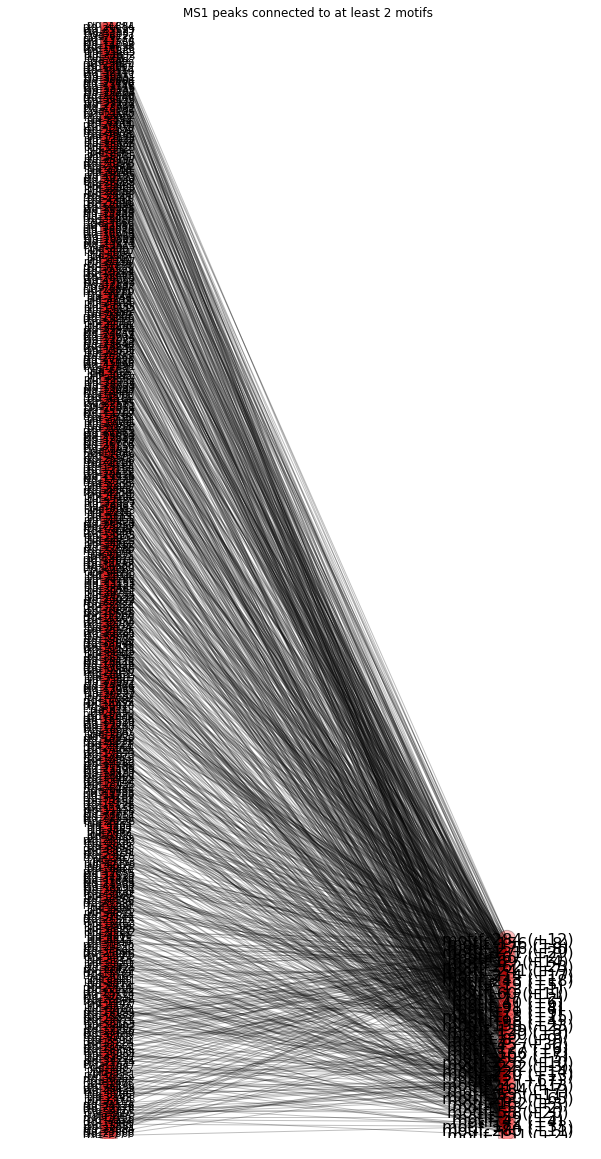

In [13]:
doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=2, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

# can tweak the fig_ and spacing_ parameters to adjust the plot appearance, especially if graph is dense
# doc_nodes, doc_motifs, motif_idx = plot_bipartite(G, min_degree=3, fig_width=10, fig_height=20, spacing_left=1, spacing_right=2)

We can also plot the fragmentation spectra of these MS1 peaks of interest, coloring their MS2 peaks by the motifs. First, we set up some objects that would be used later.

In [14]:
# find out which words belong to which M2M
word_map, motif_words = ms2lda.print_motif_features(selected_motifs=motifs_of_interest, quiet=True)
    
# map each motif to the colourmap too
# http://matplotlib.org/1.2.1/mpl_examples/pylab_examples/show_colormaps.hires.png
norm = mpl.colors.Normalize(vmin=min(motif_idx.values()), vmax=max(motif_idx.values()))
cmap = cm.gist_rainbow
motif_colour = cm.ScalarMappable(norm=norm, cmap=cmap)

<h2>4. Example</h2>

Using motif 58 and 19 as suggested by Justin

In [15]:
# check their respective peak IDs and see if any overlap
peak_ids1 = get_peak_ids_of_m2m(G, 58)
peak_ids2 = get_peak_ids_of_m2m(G, 19)
overlap = peak_ids1.intersection(peak_ids2)

print peak_ids1
print
print peak_ids2
print
print overlap

set([33793, 4331, 2820, 2951, 31468, 23564, 25999, 34065, 2967, 4378, 14239, 4260, 6063, 1073, 25267, 4276, 33722, 16063, 16126, 4427, 18756, 6087, 26995, 34381, 1102, 33108, 32334, 31830, 34391, 2852, 16092, 1117, 25054, 5985, 4587, 33516, 31346, 25075, 4341, 1087, 7676, 25086])

set([33376, 18337, 9034, 9259, 9071, 23984, 33815, 30232, 33851, 24157, 25054])

set([25054])


In [16]:
d = np.nonzero((ms2lda.ms1['peakID']==25054).values)[0]
d = np.asscalar(d)

In [17]:
print ms2lda.vocab.shape

(4496,)


In [18]:
for d in range(ms2lda.model.D):

    document = ms2lda.df.iloc[[d]]
    word_idx = utils.word_indices(document)
    results = {}
    for pos in range(len(word_idx)):
        n = word_idx[pos]
        k = ms2lda.model.Z[(d, pos)]
        if k in motifs_of_interest:
            word = ms2lda.vocab[n]
            if word in results:
                results[word].append(k)
            else:
                results[word] = [k]
                
    found = False
    lim = 20
    for word in results:
        topics = sorted(results[word])
        if len(topics) > lim and len(set(topics))>1:
            for k in topics:
                if ms2lda.doc_topic[d, k] > 0:
                    found = True

    if found:
        print "Document %d" % d
        display(ms2lda.ms1.iloc[[d]])
        for word in results:
            topics = sorted(results[word])
            if len(topics) > lim:
                print "%s --> %d words : %s" % (word, len(topics), topics)
                print

Document 6


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33,33,0,1,562.308,81.033514,766053,1,0,0,C5H5O


fragment_53.03888 --> 88 words : [91, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_81.03334 --> 99 words : [284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 28

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
317,317,0,1,240.354,105.069637,745889.5625,1,0,0,C8H9


fragment_103.05448 --> 31 words : [58, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276]

fragment_105.07019 --> 100 words : [276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276]

loss_26.01543 --> 34 words : [276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276]

fragment_53.03888 --> 25 words : [276, 276, 276, 276, 276, 276, 276, 276

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
402,402,0,1,420.52,108.044322,34856424,1,0,0,C6H6ON


fragment_126.05563 --> 98 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_53.03888 --> 95 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 284, 284, 284, 284, 284, 284]

loss_55.00558 --> 95 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 9

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
413,413,0,1,402.687,108.044373,986085.25,1,0,0,C6H6ON


fragment_126.05563 --> 98 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_53.03888 --> 95 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 284, 284, 284, 284]

loss_55.00558 --> 95 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
424,424,0,1,667.614,109.028429,1310000.25,1,0,0,C6H5O2


fragment_109.02882 --> 49 words : [284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_53.03888 --> 54 words : [58, 91, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_81.03334 --> 100 words : [284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
932,932,0,1,531.059,118.086199,1698129920,1,0,0,C5H12O2N


loss_60.02094 --> 53 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

loss_59.01322 --> 34 words : [184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_118.08614 --> 100 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]

fragment_58.06552 --> 53 words : [79, 79, 79, 184, 184, 184, 184, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
943,943,0,1,365.689,118.086248,3415746.5,1,0,0,C5H12O2N


loss_46.00539 --> 100 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

loss_60.02094 --> 25 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_118.08614 --> 32 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]

fragment_58.06552 --> 25 words : [79, 79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
949,949,0,1,378.542,118.086261,3440428.75,1,0,0,C5H12O2N


loss_46.00539 --> 100 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

loss_60.02094 --> 25 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_118.08614 --> 33 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]

fragment_58.06552 --> 25 words : [79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1087,1087,0,1,260.221,121.06479,5128256,1,0,0,C8H9O


fragment_53.03888 --> 57 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 91, 91]

fragment_93.06981 --> 47 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_91.05413 --> 31 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

loss_18.00923 --> 74 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1385,1385,0,1,667.614,127.038947,5368997,1,0,0,C6H7O3


loss_46.00539 --> 23 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

fragment_81.03334 --> 23 words : [129, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

Document 124


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1398,1398,0,1,467.234,127.038997,2580205.25,1,0,0,C6H7O3


fragment_53.03888 --> 28 words : [69, 69, 69, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_127.03868 --> 33 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_18.00923 --> 33 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_98.98469 --> 58 words : [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]

loss_46.00539 --> 56 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1708,1708,0,1,613.388,129.054577,5021718,1,0,0,C6H9O3


loss_60.02094 --> 70 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

loss_46.00539 --> 37 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

loss_74.0003 --> 33 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

fragment_57.0337 --> 29 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 34 words : [131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
1733,1733,0,1,489.128,129.065966,1042811.9375,1,0,0,C5H9O2N2


fragment_129.06581 --> 100 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

fragment_56.04977 --> 23 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 174]

Document 156


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2078,2078,0,1,433.349,131.081542,1243712.625,1,0,0,C5H11O2N2


loss_59.00065 --> 99 words : [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

loss_59.037 --> 66 words : [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

fragment_60.05587 --> 25 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 8

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
2572,2572,0,1,636.289,134.064044,991313,1,0,0,C3H9O3N2[C13]


fragment_98.06001 --> 26 words : [98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_88.05865 --> 41 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

loss_46.00539 --> 41 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

loss_59.037 --> 91 words : [151, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3352,3352,0,1,556.011,145.047106,2896769.75,1,0,0,C2H5O2N6


fragment_85.02832 --> 21 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 27 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131]

Document 217


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3363,3363,0,1,667.614,145.049507,6715682,1,0,0,C6H9O4


loss_60.02094 --> 100 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_61.02854 --> 26 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3385,3385,0,1,478.834,145.049556,2939408,1,0,0,C6H9O4


loss_60.02094 --> 100 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3404,3404,0,1,467.234,145.049561,7991423.5,1,0,0,C6H9O4


loss_60.02094 --> 100 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_97.02839 --> 21 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 40 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3747,3747,0,1,613.388,147.065142,5124866,1,0,0,C6H11O4


fragment_85.02832 --> 36 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 99 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 233


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3772,3772,0,1,486.476,147.065256,1280027,1,0,0,C6H11O4


loss_60.02094 --> 38 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_87.04391 --> 38 words : [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]

fragment_84.0442 --> 100 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

loss_18.00923 --> 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
3978,3978,0,1,499.241,148.060359,1883389.375,1,0,0,C5H10O4N


loss_60.02094 --> 22 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_88.03919 --> 23 words : [42, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_106.04977 --> 56 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_60.04477 --> 96 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4639,4639,0,1,490.365,155.045015,571738.6875,1,0,0,C6H7O3N2


fragment_109.03967 --> 100 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

loss_46.00539 --> 100 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 26

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4646,4646,0,1,501.725,155.045062,851736,1,0,0,C6H7O3N2


fragment_109.03967 --> 100 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

loss_46.00539 --> 100 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 26

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
4907,4907,0,1,326.287,158.081213,2899555,1,0,0,C7H12O3N


fragment_84.0442 --> 100 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_70.06514 --> 35 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 174]

Document 317


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5479,5479,0,1,476.118,163.038901,2222395.25,1,0,0,C9H7O3


fragment_61.02854 --> 24 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_46.00539 --> 24 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

fragment_85.02832 --> 89 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 38 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Documen

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5504,5504,0,1,490.365,163.039055,823629.5,1,0,0,C9H7O3


fragment_61.02854 --> 24 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 38 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_46.00539 --> 24 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

fragment_85.02832 --> 89 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 319


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5554,5554,0,1,659.996,163.059853,2685874.5,1,0,0,C6H11O5


fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 22 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 46 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 320


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5572,5572,0,1,667.614,163.059895,2890047.25,1,0,0,C6H11O5


fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 46 words : [69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 321


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5590,5590,0,1,650.033,163.06001,2153199.5,1,0,0,C6H11O5


fragment_85.02832 --> 100 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 22 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 46 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 322


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5608,5608,0,1,467.234,163.060068,7313271,1,0,0,C6H11O5


fragment_61.02854 --> 21 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 99 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 43 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 323


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5634,5634,0,1,719.563,163.07941,738826.875,1,0,0,C5H12O4N[C13]


fragment_85.02832 --> 80 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_18.00923 --> 73 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_57.0337 --> 33 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131]

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5689,5689,0,1,582.248,163.115836,641288.0625,1,0,0,C6H16O3N[C13]


loss_102.08728 --> 47 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_73.0285 --> 31 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_61.02854 --> 47 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_64.072 --> 32 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 66 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5839,5839,0,1,518.503,165.075762,1295761.375,1,0,0,C6H13O5


fragment_57.0337 --> 57 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131]

Document 335


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
5985,5985,0,1,377.302,166.086284,880995.75,1,0,0,C9H12O2N


fragment_103.05448 --> 25 words : [58, 58, 58, 58, 58, 58, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_166.08631 --> 61 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

loss_46.00539 --> 38 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262]

fragment_121.06489 --> 49 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_120.0804 --> 38 words : [115, 115, 115, 11

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6087,6087,0,1,282.677,166.122646,799479.0625,1,0,0,C10H16ON


fragment_120.0804 --> 100 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_103.05448 --> 37 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_121.06489 --> 31 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

Document 342


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6158,6158,0,1,672.751,168.065489,544004.375,1,0,0,C8H10O3N


fragment_127.03868 --> 29 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_69.03368 --> 96 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 129, 131, 131]

Document 383


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
6957,6957,0,1,513.556,175.071339,1157693.25,1,0,0,C6H11O4N2


fragment_133.06148 --> 38 words : [42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42]

fragment_84.0442 --> 41 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_88.03919 --> 100 words : [42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42]

fragment_158.04483 --> 41 words : [42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7512,7512,0,1,600.951,180.086521,11014748,1,0,0,C6H14O5N


fragment_127.03868 --> 50 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131]

fragment_145.04997 --> 30 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_69.03368 --> 39 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7547,7547,0,1,465.819,180.086641,4311435.5,1,0,0,C6H14O5N


fragment_85.02832 --> 22 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 419


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7770,7770,0,1,584.728,182.081249,20474944,1,0,0,C9H12O3N


loss_59.037 --> 40 words : [211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211, 211]

fragment_165.05578 --> 35 words : [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]

loss_17.02527 --> 36 words : [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214]

loss_46.00539 --> 88 words : [262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262, 262,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
7830,7830,0,1,613.388,183.086304,48964084,1,0,0,C6H15O6


fragment_57.0337 --> 21 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69]

fragment_85.02832 --> 22 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 100 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131]

Document 429


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
8073,8073,0,1,419.279,185.091959,15173984,1,0,0,C8H13O3N2


fragment_60.04477 --> 26 words : [211, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 473


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9034,9034,0,1,364.448,194.081159,4002022.25,1,0,0,C10H12O3N


fragment_108.04425 --> 63 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_80.04949 --> 25 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_53.03888 --> 34 words : [58, 58, 58, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 115]

loss_18.00923 --> 35 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

loss_17.02527 --> 37 words : [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9071,9071,0,1,378.542,194.081202,2941392.25,1,0,0,C10H12O3N


fragment_108.04425 --> 63 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_80.04949 --> 35 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]

fragment_53.03888 --> 34 words : [19, 58, 58, 58, 58, 58, 58, 58, 58, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 115, 115]

loss_18.00923 --> 35 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

loss_17.02527 --> 38 words : [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9146,9146,0,1,281.432,194.117577,1371174.625,1,0,0,C11H16O2N


fragment_103.05448 --> 32 words : [58, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_120.0804 --> 100 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

Document 479


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9166,9166,0,1,277.702,194.146779,2886533.25,1,0,0,C8H21O4[C13]


fragment_120.0804 --> 91 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_98.06001 --> 34 words : [98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_103.05448 --> 27 words : [58, 58, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

Document 482


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9228,9228,0,1,618.594,195.086253,666660.5625,1,0,0,C7H15O6


fragment_81.03334 --> 100 words : [129, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_109.02882 --> 52 words : [284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

Document 496


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9510,9510,0,1,590.942,198.03725,554328.25,1,0,0,C12H8NS


fragment_127.03868 --> 44 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131]

fragment_145.04997 --> 64 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9522,9522,0,1,637.583,198.052515,941122.875,1,0,0,C5H13O5NP


loss_71.01347 --> 26 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_61.02854 --> 60 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_163.06064 --> 30 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_91.03925 --> 50 words : [129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_127.03868 --> 27 words :

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
9550,9550,0,1,627.569,198.097174,9659914,1,0,0,C6H16O6N


fragment_61.02854 --> 28 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_163.06064 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_91.03925 --> 35 words : [129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 42 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
10939,10939,0,1,465.819,209.101972,3465742.25,1,0,0,C8H17O6


fragment_145.04997 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 21 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 559


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
10958,10958,0,1,484.002,209.103269,1329467.375,1,0,0,C9H21OS2


fragment_145.04997 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 21 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 563


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
11077,11077,0,1,460.835,210.097264,1783887.75,1,0,0,C7H16O6N


fragment_85.02832 --> 62 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_87.04391 --> 75 words : [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]

fragment_69.03368 --> 79 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
11855,11855,0,1,501.725,217.081924,688452.25,1,0,0,C8H13O5N2


fragment_84.0442 --> 100 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_106.04977 --> 66 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_60.04477 --> 46 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
12109,12109,0,1,269.685,218.138657,668425.0625,1,0,0,C10H20O4N


loss_60.02094 --> 100 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_112.11182 --> 26 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

fragment_172.13416 --> 21 words : [280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]

loss_149.06869 --> 30 words : [156, 156, 156, 156, 156, 156, 156, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13037,13037,0,1,465.819,226.128462,29262550,1,0,0,C8H20O6N


fragment_127.03868 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 51 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fr

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13338,13338,0,1,427.098,228.10577,3502941.5,1,0,0,C11H18O2NS


loss_143.05783 --> 51 words : [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151]

fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 174, 174]

fragment_84.0442 --> 88 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13364,13364,0,1,411.615,228.122753,597762,1,0,0,C11H18O4N


fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 174, 174]

fragment_84.0442 --> 88 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

Document 653


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13409,13409,0,1,416.798,228.134037,559314.0625,1,0,0,C10H18O3N3


fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 174]

fragment_84.0442 --> 88 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

Document 660


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13564,13564,0,1,304.981,229.118269,1820511.625,1,0,0,C10H17O4N2


fragment_116.07116 --> 100 words : [151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151, 151]

fragment_84.0442 --> 94 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
13752,13752,0,1,640.068,230.095734,1287737.875,1,0,0,C9H16O2N3S


loss_103.06338 --> 100 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]

fragment_127.03204 --> 100 words : [166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14758,14758,0,1,540.996,236.149269,7373383,1,0,0,C10H22O5N


fragment_58.06552 --> 25 words : [79, 79, 79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_119.08937 --> 89 words : [184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_118.08614 --> 99 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14784,14784,0,1,531.059,236.162438,3354991.5,1,0,0,C8H23ON4S[C13]


fragment_58.06552 --> 26 words : [79, 79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_119.08937 --> 89 words : [184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_118.08614 --> 100 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
14810,14810,0,1,531.059,236.168409,44345628,1,0,0,C11H26O2NS


fragment_58.06552 --> 26 words : [79, 79, 79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_119.08937 --> 89 words : [184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

fragment_118.08614 --> 100 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 7

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
15000,15000,0,1,509.663,239.112316,1216727.75,1,0,0,C9H19O7


fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 727


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
15551,15551,0,1,552.287,242.123274,691923.375,1,0,0,C8H20O7N


fragment_145.04997 --> 54 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_85.02832 --> 99 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.0

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16198,16198,0,1,894.39,246.181097,1700805.25,1,0,0,C11H24O3N3


fragment_58.06552 --> 58 words : [79, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184, 184]

Document 759


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16381,16381,0,1,468.47,248.112698,1048888,1,0,0,C10H18O6N


loss_179.07913 --> 47 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

loss_162.05262 --> 100 words : [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226]

loss_18.00923 --> 40 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_98.0600

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16396,16396,0,1,524.867,248.207911,1133272.125,1,0,0,C10H26O2N5


loss_117.07884 --> 54 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]

loss_130.12154 --> 99 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79]

fragment_131.12915 --> 54 words : [79, 79, 79, 79, 79, 79, 79, 79, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_118.08614 --> 100 words : [79, 79, 79, 79, 79, 79, 79, 79, 79, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16482,16482,0,1,597.228,250.092066,2327150.5,1,0,0,C9H16O7N


fragment_84.0442 --> 49 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_232.1195 --> 99 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_98.06001 --> 45 words : [98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 9

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16542,16542,0,1,595.985,250.128324,1013366.4375,1,0,0,C10H20O6N


fragment_84.0442 --> 49 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_232.1195 --> 31 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_98.06001 --> 44 words : [98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_60.04477 --> 22 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_81.03334 --> 45 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16934,16934,0,1,482.766,253.092998,3300294,1,0,0,C12H18N2PS


fragment_85.02832 --> 21 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 786


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16962,16962,0,1,439.647,253.112188,3367034.25,1,0,0,C10H23O3P2


fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 24 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 787


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
16985,16985,0,1,467.234,253.128005,35089320,1,0,0,C10H21O7


fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 23 words : [69, 69, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 788


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17013,17013,0,1,478.834,253.128006,21093862,1,0,0,C10H21O7


fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 796


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17244,17244,0,1,597.228,255.107288,2344779.5,1,0,0,C9H19O8


loss_162.05262 --> 99 words : [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17873,17873,0,1,302.479,261.090214,591962.3125,1,0,0,C12H22PS2


fragment_84.0442 --> 100 words : [158, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_56.04977 --> 24 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_86.09652 --> 29 words : [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]

fragment_70.06514 --> 50 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
17896,17896,0,1,508.423,261.094258,1623367.875,1,0,0,C7H13O5N6


fragment_84.0442 --> 73 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_115.05435 --> 25 words : [202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202]

fragment_86.09652 --> 78 words : [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158]

fragment_132.10

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18500,18500,0,1,585.967,267.119934,16595004,1,0,0,C10H23O2N2S2


loss_114.07908 --> 23 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

fragment_70.06514 --> 32 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

fragment_153.04074 --> 23 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

loss_197.05414 --> 32 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

fragment_152.05609 --> 100 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18815,18815,0,1,597.228,268.081478,535329,1,0,0,C7H19N5PS2


fragment_107.04883 --> 97 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_98.98385 --> 40 words : [243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]

fragment_84.0442 --> 82 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18831,18831,0,1,597.228,268.102418,7995996,1,0,0,C9H18O8N


loss_18.00923 --> 21 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_250.09297 --> 21 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_70.06514 --> 51 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

fragment_153.04074 --> 26 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

fragment_152.05609 --> 100 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18872,18872,0,1,469.707,268.103893,8295168,1,0,0,C12H19N3PS


loss_132.04207 --> 100 words : [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 220]

fragment_136.06239 --> 100 words : [220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 2

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18908,18908,0,1,585.967,268.123286,1688705.625,1,0,0,C10H24O3NP2


loss_116.06671 --> 85 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

loss_114.07908 --> 21 words : [162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162, 162]

fragment_250.09297 --> 21 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_70.06514 --> 51 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

fragment_153.04074 --> 26 words : [162, 162, 162, 162, 162, 162, 162, 162, 16

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
18959,18959,0,1,437.165,268.138904,9340338,1,0,0,C10H22O7N


loss_183.11033 --> 32 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

loss_179.07913 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_85.02832 --> 32 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 868


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19030,19030,0,1,465.819,270.094669,3447672.5,1,0,0,C8H20O3N3S2


loss_185.06735 --> 100 words : [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]

fragment_145.04997 --> 41 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

loss_143.05783 --> 24 words : [151, 151, 151, 151, 151, 151, 151, 151, 151,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19076,19076,0,1,554.77,270.118228,742621.875,1,0,0,C9H20O8N


fragment_145.04997 --> 52 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_110.07176 --> 29 words : [241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241]

fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19088,19088,0,1,478.834,270.154525,29691078,1,0,0,C10H24O7N


fragment_97.02839 --> 26 words : [129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 37 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 63 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131]

fragment_69.03368 --> 22 words : [129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [129,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19129,19129,0,1,467.234,270.154541,35260480,1,0,0,C10H24O7N


fragment_145.04997 --> 37 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 64 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131]

fragment_69.03368 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19224,19224,0,1,592.258,272.087582,916740.3125,1,0,0,C12H19O2NPS


fragment_85.02832 --> 64 words : [129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 21 words : [69, 69, 69, 69, 69, 69, 69, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 877


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19260,19260,0,1,459.598,272.112846,672431.375,1,0,0,C7H23N5PS2


loss_162.05262 --> 100 words : [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226]

fragment_85.02832 --> 38 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 30 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 878


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19276,19276,0,1,597.228,272.133669,3061076.5,1,0,0,C9H22O8N


loss_197.08988 --> 29 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_85.02832 --> 62 words : [129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_179.07913 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_69.03368 --> 21 words : [69, 69, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19299,19299,0,1,588.459,272.133788,4447610,1,0,0,C9H22O8N


loss_197.08988 --> 29 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_85.02832 --> 64 words : [129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

loss_179.07913 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

Document 880


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19322,19322,0,1,469.707,272.158965,534101.875,1,0,0,C14H27NPS


fragment_85.02832 --> 38 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 30 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 881


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
19338,19338,0,1,463.346,272.159477,538937,1,0,0,C14H27NPS


fragment_85.02832 --> 38 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 30 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 909


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
20222,20222,0,1,435.83,277.147397,520255.15625,1,0,0,C13H25O4S


loss_194.08592 --> 24 words : [241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241]

fragment_110.07176 --> 100 words : [241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241, 241]

fragment_86.09652 --> 78 words : [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 15

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
20279,20279,0,1,753.568,277.165759,5352950,1,0,0,C14H29OS2


loss_158.11694 --> 48 words : [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

loss_186.11136 --> 56 words : [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

fragment_91.05413 --> 56 words : [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

fragment_119.04874 --> 48 words : [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

fragment_277.16473 --> 37 words :

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
20322,20322,0,1,652.517,278.063463,1722221.5,1,0,0,C9H16O3N3S2


fragment_261.03653 --> 22 words : [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]

loss_17.02527 --> 22 words : [214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214, 214]

fragment_98.98469 --> 100 words : [127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]

fragment_81.03334 --> 21 words : [129, 129, 129, 129, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

loss_179.07913 --> 100 words : [53, 5

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
20603,20603,0,1,366.931,279.154769,2203030.75,1,0,0,C13H28O2PS


fragment_145.04997 --> 56 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
20616,20616,0,1,379.781,279.154863,3696185.75,1,0,0,C13H28O2PS


fragment_145.04997 --> 56 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21234,21234,0,1,409.09,281.149324,540884.6875,1,0,0,C8H22O3N6P


fragment_85.02832 --> 100 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 956


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21806,21806,0,1,663.894,289.091471,707233.375,1,0,0,C6H18O7N4P


fragment_85.02832 --> 30 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 957


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21821,21821,0,1,671.332,289.09153,556900.75,1,0,0,C6H18O7N4P


fragment_85.02832 --> 30 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 958


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21836,21836,0,1,662.655,289.150244,564230.6875,1,0,0,C13H26ON2PS


fragment_85.02832 --> 30 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_70.06514 --> 100 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 961


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
21892,21892,0,1,482.766,291.048833,3696419,1,0,0,C10H17O2N2P2S


fragment_98.06001 --> 38 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_147.04375 --> 39 words : [55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 82]

fragment_60.05587 --> 21 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_131.12915 --> 27 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_278.05564 --> 29 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

Document 965


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22068,22068,0,1,560.987,291.097302,570445.125,1,0,0,C8H16O4N6P


fragment_98.06001 --> 74 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_130.06468 --> 39 words : [82, 82, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202, 202]

fragment_97.07643 --> 23 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_131.12915 --> 55 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

loss_152.0579 --> 82 words : [82, 82, 82, 82, 82, 82, 82,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22190,22190,0,1,646.272,291.118441,1183984.5,1,0,0,C5H20O6N6P


fragment_98.06001 --> 73 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 47 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_55.05466 --> 39 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_165.07004 --> 24 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_114.10279 --> 40 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22327,22327,0,1,641.31,291.129803,640726.3125,1,0,0,C12H24O2N2PS


fragment_98.06001 --> 73 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 47 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_55.05466 --> 42 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_83.06041 --> 41 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 166]

fragment_165.07004 --> 24 words : [82, 82, 82,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22412,22412,0,1,754.836,291.163146,7248397,1,0,0,C14H27O4S


fragment_425.2164 --> 49 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_98.06001 --> 81 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 98]

fragment_97.07643 --> 28 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_131.12915 --> 65 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22493,22493,0,1,630.064,291.163167,7319830.5,1,0,0,C14H27O4S


fragment_98.06001 --> 73 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 46 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_55.05466 --> 39 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_83.06041 --> 41 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 241]

fragment_165.07004 --> 24 words : [82, 82, 82, 82, 82, 82, 82,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22662,22662,0,1,547.239,291.665037,1420279.75,1,0,0,NaN


fragment_84.0442 --> 89 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_98.06001 --> 65 words : [82, 82, 82, 82, 82, 82, 82, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_70.06514 --> 36 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Document 973


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22685,22685,0,1,477.597,292.087355,1114450.25,1,0,0,C20H10N3


fragment_114.10279 --> 25 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 25 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_131.12915 --> 30 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

loss_162.03528 --> 86 words : [59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59]

fragment_84.04486 --> 100 words : [59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 5

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22711,22711,0,1,463.346,292.087363,1861964.25,1,0,0,C20H10N3


fragment_114.10279 --> 22 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 25 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_131.12915 --> 26 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_98.06001 --> 40 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 98]

loss_162.03528 --> 86 words : [59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 220, 220]

fragment_84.04486 --> 100 w

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
22737,22737,0,1,545.999,292.102321,749744.5,1,0,0,C15H20ONP2


fragment_84.0442 --> 89 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

loss_162.05262 --> 100 words : [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23395,23395,0,1,386.308,298.09682,2876561.75,1,0,0,C10H22O5NP2


loss_162.03528 --> 100 words : [59, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220]

fragment_136.06239 --> 100 words : [220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 22

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23540,23540,0,1,553.527,300.128869,1534300.625,1,0,0,C10H22O9N


loss_197.08988 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_57.0337 --> 31 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 71 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragme

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23564,23564,0,1,595.985,300.144131,2291148,1,0,0,C9H27N5PS2


fragment_93.06981 --> 21 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_91.05413 --> 25 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_282.13229 --> 58 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_103.05448 --> 30 words : [53, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

loss_197.08988 --> 30 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_121.06489 --> 100 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23664,23664,0,1,236.287,301.212088,1931922.125,1,0,0,C17H34PS


fragment_147.07588 --> 29 words : [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]

fragment_84.0442 --> 100 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_83.06041 --> 26 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

fragment_129.06581 --> 33 words : [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 174]

Docum

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
23714,23714,0,1,612.152,302.144325,991429.9375,1,0,0,C10H24O9N


fragment_87.04391 --> 84 words : [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]

loss_179.07913 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

loss_197.08988 --> 86 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 5

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
24212,24212,0,1,244.41,307.190362,541844.125,1,0,0,C18H27O4


fragment_103.05448 --> 24 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

fragment_120.0804 --> 64 words : [115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115]

loss_18.00923 --> 31 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_80.04949 --> 23 words : [91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 115, 115]

fragment_86.09652 --> 30 words : [158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
24352,24352,0,1,233.801,308.185593,3730373.5,1,0,0,C17H26O4N


fragment_165.05388 --> 40 words : [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]

fragment_136.07599 --> 99 words : [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]

fragment_119.04874 --> 27 words : [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

fragment_182.08217 --> 59 words : [17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
24885,24885,0,1,453.384,312.130213,3642545.5,1,0,0,C14H23ON3PS


loss_132.04207 --> 32 words : [156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156]

fragment_81.03334 --> 22 words : [129, 129, 129, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_85.02832 --> 38 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 24 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131]

Document 1052


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
24924,24924,0,1,455.865,312.165179,1036039.1875,1,0,0,C12H26O8N


fragment_81.03334 --> 22 words : [129, 129, 129, 129, 129, 129, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_85.02832 --> 38 words : [129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 24 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1068


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25267,25267,0,1,432.107,318.154787,968660.8125,1,0,0,C14H24O7N


fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131]

fragment_145.04997 --> 29 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 78 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_121.06489 --> 78 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25498,25498,0,1,704.128,324.128892,827401.125,1,0,0,C12H22O9N


loss_162.05262 --> 100 words : [226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226, 226]

fragment_85.02832 --> 32 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 29 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 226]

Document 1078


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25506,25506,0,1,474.881,324.128928,940555.625,1,0,0,C12H22O9N


loss_179.07913 --> 29 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 29 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 100 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25561,25561,0,1,659.996,325.112789,13895505,1,0,0,C9H23ON6P2S


fragment_145.04997 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 21 words : [69, 69, 69, 69, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1086


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25598,25598,0,1,671.332,325.112877,13108415,1,0,0,C9H23ON6P2S


fragment_145.04997 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1087


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
25635,25635,0,1,514.793,325.112938,4332192,1,0,0,C9H23ON6P2S


fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 28 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1095


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
26010,26010,0,1,641.31,330.139257,1141989.25,1,0,0,C16H20ON5S


fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_145.04997 --> 32 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 22 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_57.0337 --> 54 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 71 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
26023,26023,0,1,648.791,330.139405,991097.8125,1,0,0,C11H24O10N


fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_145.04997 --> 32 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 22 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_57.0337 --> 54 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 71 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
26718,26718,0,1,670.092,342.139442,3868974.5,1,0,0,C12H24O10N


fragment_97.02839 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 45 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

loss_197.08988 --> 45 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_69.03368 --> 23 words : [129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_127.03868 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 1

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28506,28506,0,1,837.513,357.249505,4582468.5,1,0,0,C19H38N2PS


fragment_84.08071 --> 61 words : [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]

fragment_70.06514 --> 94 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 82]

Document 1169


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28595,28595,0,1,655.001,360.149872,21807478,1,0,0,C16H28O4NP2


fragment_127.03868 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 61 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
28902,28902,0,1,799.464,363.184318,1292590.375,1,0,0,C9H27O9N6


fragment_301.15234 --> 38 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_363.18115 --> 31 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_114.10279 --> 36 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_97.07643 --> 33 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_157.10838 --> 35 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_275.17137 --> 37 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
30291,30291,0,1,317.165,370.170784,727435.625,1,0,0,C14H28O10N


fragment_163.06064 --> 45 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 79 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
30326,30326,0,1,514.793,371.154901,1961539.125,1,0,0,C11H29O2N6P2S


fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 44 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 24 words : [129, 129, 129, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
30708,30708,0,1,314.478,379.159851,893831.75,1,0,0,C10H28O9N4P


fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_99.04454 --> 34 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_103.03863 --> 52 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31280,31280,0,1,640.068,386.165452,1452474.5,1,0,0,C18H30O4NP2


fragment_85.02832 --> 34 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1242


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31307,31307,0,1,655.001,386.165714,1802204.375,1,0,0,C27H20N3


loss_18.00923 --> 23 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_85.02832 --> 34 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1245


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31388,31388,0,1,489.128,388.147588,773630.375,1,0,0,C14H32O5NP2S


fragment_145.04997 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_136.06239 --> 44 words : [220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220]

fragment_85.02832 --> 37 words : [129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1246


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31406,31406,0,1,514.793,388.181189,29452342,1,0,0,C18H32O4NP2


fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_145.04997 --> 65 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31671,31671,0,1,314.478,397.170576,802466.1875,1,0,0,C13H31O2N6P2S


fragment_163.06064 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 43 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 99 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_103.03863 --> 74 words : [129, 129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31774,31774,0,1,522.391,402.160606,636921.5,1,0,0,NaN


loss_197.08988 --> 66 words : [53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53]

fragment_145.04997 --> 33 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_70.06514 --> 23 words : [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

fragment_127.03868 --> 63 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 57 words : [129, 129, 129,

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31830,31830,0,1,240.354,404.206626,18565472,1,0,0,NaN


fragment_105.07019 --> 100 words : [276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276]

fragment_121.06489 --> 37 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_93.06981 --> 26 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 276, 276, 276, 276, 276, 276, 276, 276]

Document 1276


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31909,31909,0,1,617.355,414.160443,2386071.5,1,0,0,NaN


fragment_85.02832 --> 26 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1277


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31934,31934,0,1,411.615,414.196617,1562132,1,0,0,NaN


fragment_69.03368 --> 22 words : [69, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 45 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 59 words : [129, 129, 129, 129, 129

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
31956,31956,0,1,313.227,414.19697,1531270,1,0,0,NaN


loss_155.07965 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_259.11581 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 64 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32075,32075,0,1,203.264,417.263413,2814379.75,1,0,0,NaN


fragment_81.03334 --> 30 words : [58, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

Document 1284


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32109,32109,0,1,463.346,420.150114,660155.9375,1,0,0,NaN


fragment_145.04997 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 48 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1286


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32140,32140,0,1,448.381,420.186391,787943.75,1,0,0,NaN


fragment_145.04997 --> 23 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 47 words : [129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1292


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32216,32216,0,1,650.033,428.176313,28206894,1,0,0,NaN


loss_18.00923 --> 25 words : [260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260, 260]

fragment_87.04391 --> 22 words : [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]

fragment_85.02832 --> 21 words : [129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1294


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32275,32275,0,1,619.834,430.155495,1007433.6875,1,0,0,NaN


fragment_84.0442 --> 30 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_232.08279 --> 47 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment_250.09297 --> 100 words : [222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222, 222]

fragment

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32317,32317,0,1,514.793,432.207612,1289035.75,1,0,0,NaN


fragment_97.02839 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 59 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32376,32376,0,1,648.791,434.186994,1732606.5,1,0,0,NaN


fragment_61.02854 --> 96 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_163.06064 --> 97 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32629,32629,0,1,539.755,442.192133,4516781,1,0,0,NaN


fragment_85.02832 --> 23 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1323


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
32860,32860,0,1,509.663,456.207472,6633608,1,0,0,NaN


fragment_85.02832 --> 23 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1328


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33011,33011,0,1,494.275,469.208264,1224935.125,1,0,0,NaN


fragment_84.0442 --> 25 words : [174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174, 174]

fragment_178.07822 --> 24 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_98.06001 --> 69 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98]

fragment_157.10838 --> 59 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82]

fragment_55.05466 --> 46 words : [82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33108,33108,0,1,207.077,471.23791,991053.8125,1,0,0,NaN


fragment_105.07019 --> 46 words : [276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276, 276]

fragment_121.06489 --> 100 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58]

fragment_53.03888 --> 48 words : [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 276, 276, 276, 276, 276, 276]

Document 1337


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33217,33217,0,1,520.976,486.181867,1097062.125,1,0,0,NaN


fragment_127.03868 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 62 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_99.04454 --> 28 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33234,33234,0,1,661.235,487.16565,6549144,1,0,0,NaN


fragment_145.04997 --> 47 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 22 words : [129, 129, 129, 129

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33338,33338,0,1,652.517,492.192472,1102295.25,1,0,0,NaN


fragment_127.03868 --> 43 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 66 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33357,33357,0,1,635.046,492.192576,641764.375,1,0,0,NaN


fragment_127.03868 --> 44 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131]

fragment_145.04997 --> 66 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33425,33425,0,1,661.235,505.176402,4808667,1,0,0,NaN


fragment_127.03868 --> 26 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 58 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33470,33470,0,1,568.532,506.186983,1200896.375,1,0,0,NaN


fragment_85.02832 --> 24 words : [129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1354


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33562,33562,0,1,659.996,522.202676,74982168,1,0,0,NaN


fragment_145.04997 --> 61 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33603,33603,0,1,670.092,522.202799,65583672,1,0,0,NaN


fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 61 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
33656,33656,0,1,666.373,525.211157,567810.375,1,0,0,NaN


fragment_145.04997 --> 50 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_97.02839 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 37 words : 

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34068,34068,0,1,656.24,580.208708,1636948.25,1,0,0,NaN


fragment_127.03868 --> 33 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 78 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34118,34118,0,1,659.996,590.22916,2226019.75,1,0,0,NaN


fragment_85.02832 --> 38 words : [129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Document 1387


,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34162,34162,0,1,657.516,603.153482,1113125.875,1,0,0,NaN


fragment_261.03653 --> 32 words : [243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243, 243]

fragment_163.06064 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 33 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 73 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_98.98385 --> 98 words : [243, 24

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34263,34263,0,1,690.253,633.271325,587176,1,0,0,NaN


fragment_84.08071 --> 100 words : [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]

fragment_81.03334 --> 38 words : [284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284, 284]

fragment_85.02832 --> 27 words : [131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_69.03368 --> 30 words : [69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 131, 131, 131, 131, 131, 131, 131, 131, 131]

Docum

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34294,34294,0,1,677.736,649.218679,1740094.125,1,0,0,NaN


fragment_127.03868 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 68 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_69.03368 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34401,34401,0,1,666.373,667.2285,2478907,1,0,0,NaN


fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_145.04997 --> 71 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34430,34430,0,1,676.494,667.228943,4032921.75,1,0,0,NaN


fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131]

fragment_145.04997 --> 71 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34510,34510,0,1,677.736,684.255481,21881570,1,0,0,NaN


fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 68 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_163.06064 --> 29 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34588,34588,0,1,685.234,829.280913,1226801.375,1,0,0,NaN


fragment_163.06064 --> 26 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 72 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34603,34603,0,1,676.494,829.281206,815349,1,0,0,NaN


fragment_163.06064 --> 26 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 22 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 72 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 131, 13

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34618,34618,0,1,686.519,846.307934,4944562.5,1,0,0,NaN


fragment_163.06064 --> 31 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_127.03868 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 80 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34652,34652,0,1,689.007,991.333787,950191.9375,1,0,0,NaN


fragment_127.03868 --> 25 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_163.06064 --> 32 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 85 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 99 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34667,34667,0,1,689.007,1008.360999,2832173.25,1,0,0,NaN


fragment_127.03868 --> 24 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_145.04997 --> 83 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_325.11195 --> 30 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34690,34690,0,1,661.235,1009.344582,941096.8125,1,0,0,NaN


fragment_127.03868 --> 28 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131, 131, 131]

fragment_145.04997 --> 91 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_325.11195 --> 21 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

,peakID,MSnParentPeakID,msLevel,rt,mz,intensity,Sample,GroupPeakMSn,CollisionEnergy,annotation
34707,34707,0,1,663.894,1026.371495,1586896,1,0,0,NaN


fragment_127.03868 --> 27 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 131]

fragment_145.04997 --> 88 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_325.11195 --> 38 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129]

fragment_85.02832 --> 100 words : [129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 129, 12

 - M2M_58	: Ethylphenol substructure (e.g. resulting from Tyramine - MzCloud)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),
 - M2M_19	: Ferulic acid substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to results/example1_0.pdf


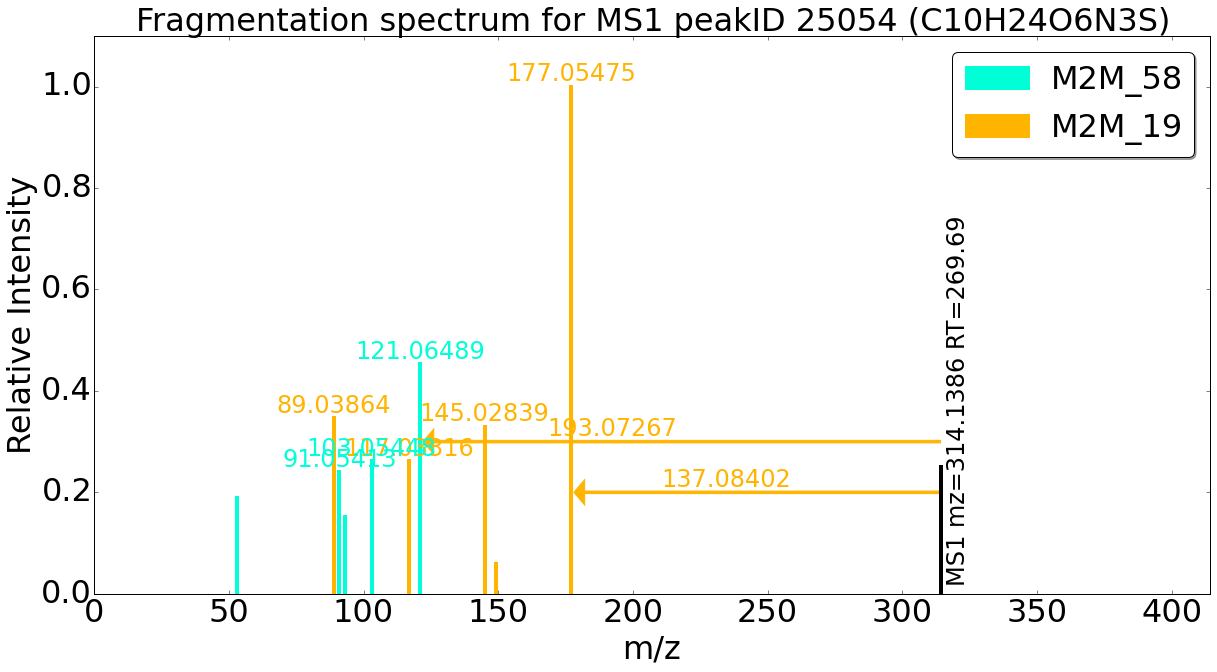

 - M2M_58	: Ethylphenol substructure (e.g. resulting from Tyramine - MzCloud)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

Figure saved to results/example1_1.pdf


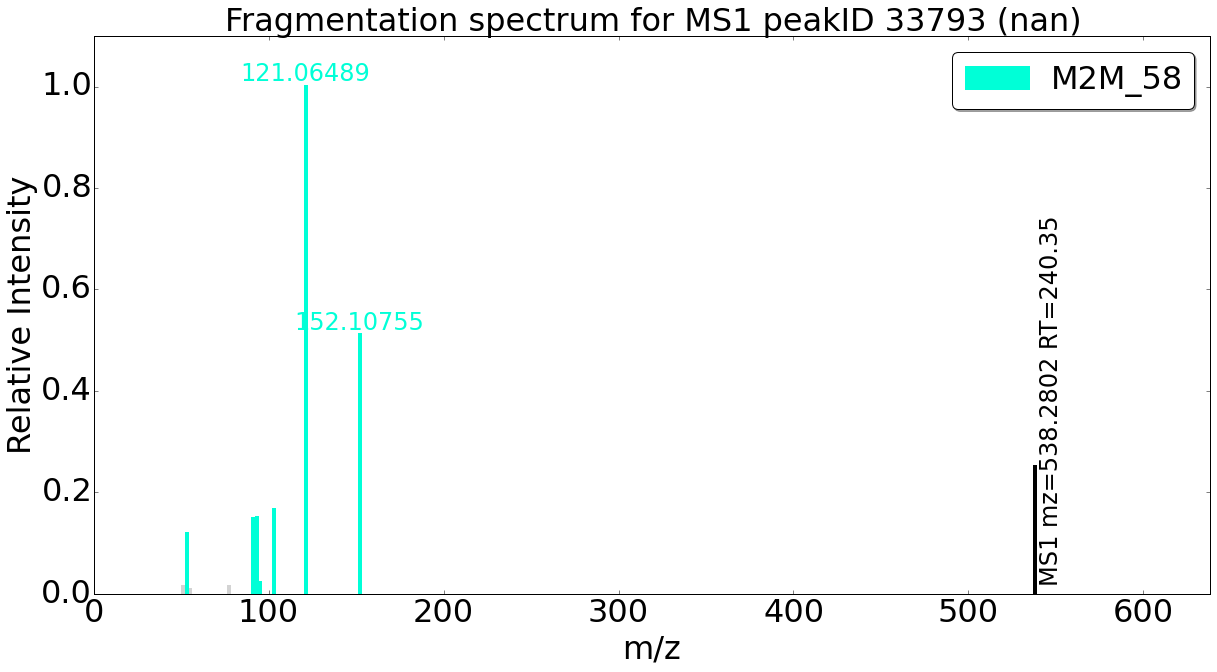

 - M2M_58	: Ethylphenol substructure (e.g. resulting from Tyramine - MzCloud)
		  fragment_121.06489 (0.412),fragment_103.05448 (0.103),fragment_93.06981 (0.082),fragment_53.03888 (0.080),fragment_91.05413 (0.071),fragment_152.10755 (0.027),loss_68.02601 (0.026),fragment_138.05067 (0.023),fragment_166.12292 (0.023),fragment_95.04936 (0.013),

Figure saved to results/example1_2.pdf


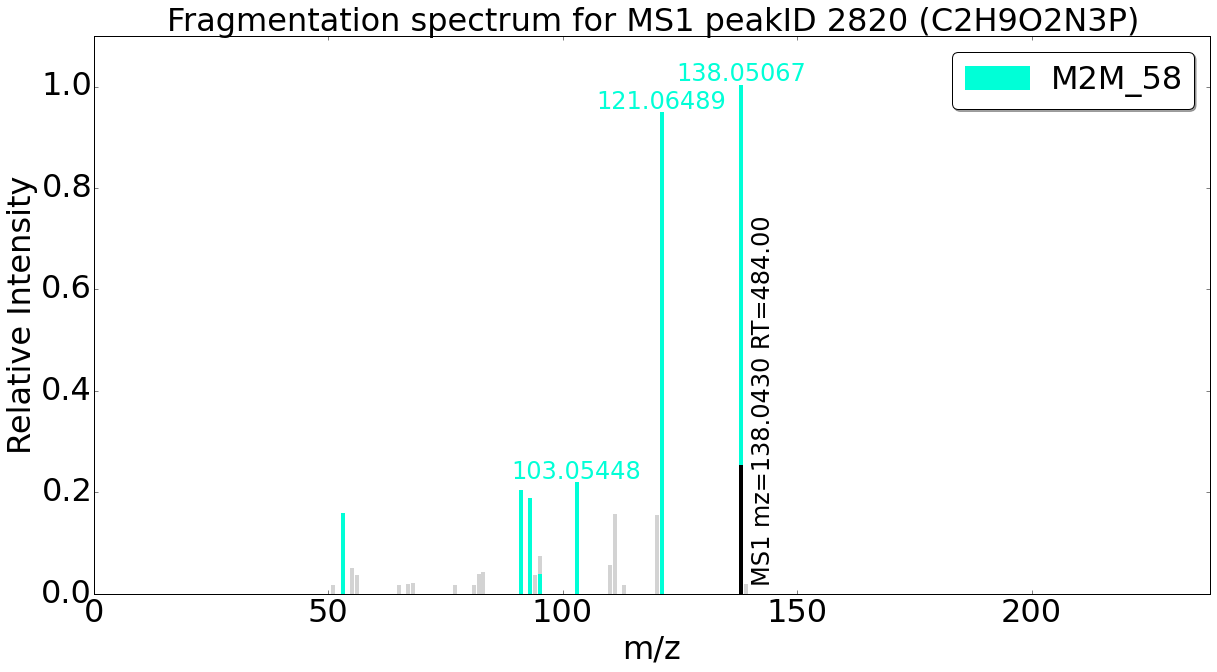

 - M2M_19	: Ferulic acid substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to results/example1_3.pdf


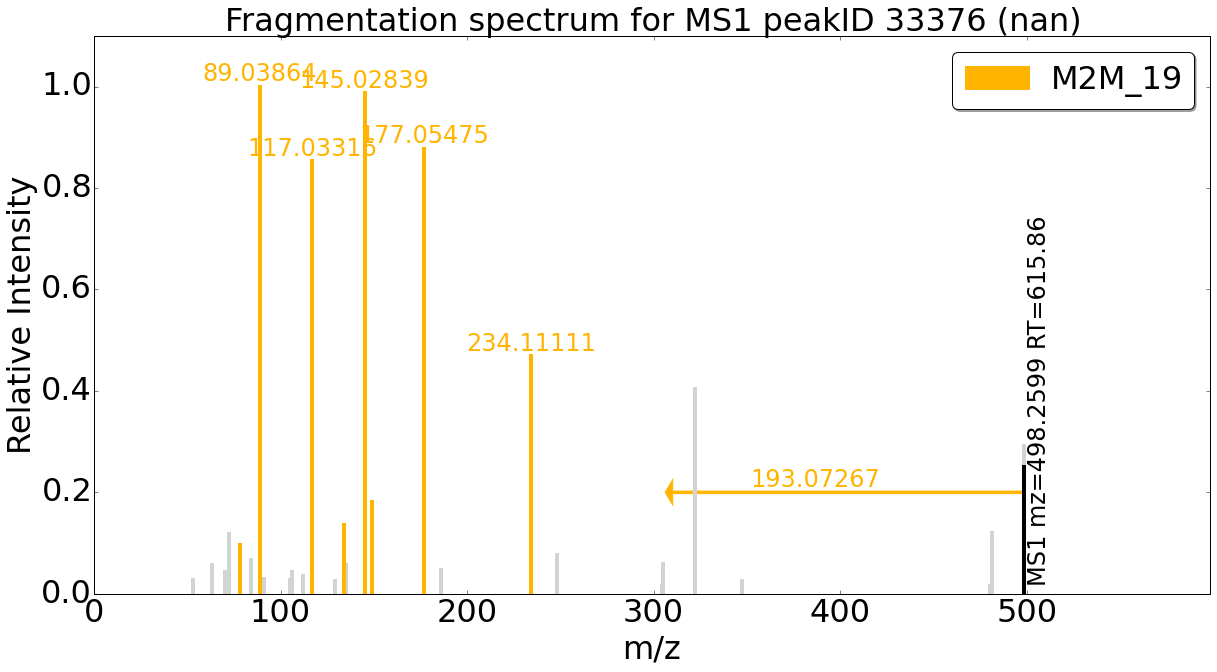

 - M2M_19	: Ferulic acid substructure
		  fragment_177.05475 (0.191),fragment_89.03864 (0.146),fragment_145.02839 (0.137),fragment_117.03316 (0.115),fragment_364.22203 (0.035),fragment_149.05998 (0.028),fragment_307.17496 (0.027),loss_137.08402 (0.024),loss_130.12154 (0.024),loss_193.07267 (0.016),loss_176.10859 (0.016),fragment_100.07536 (0.013),fragment_171.1487 (0.012),fragment_134.03657 (0.012),fragment_78.04655 (0.011),fragment_234.11111 (0.011),

Figure saved to results/example1_4.pdf


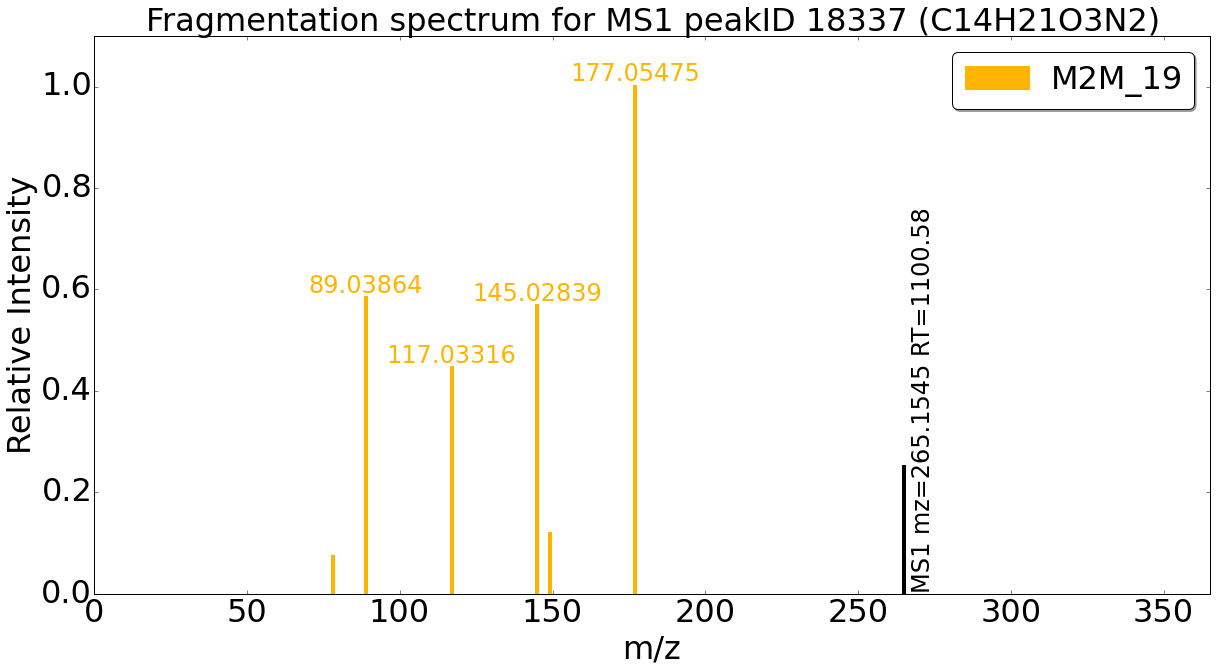

In [19]:
# print some fragmentation spectra
m2m_list = [58, 19]
ms1_list = [25054, 33793, 2820, 33376, 18337]

# loop over all ms1 in ms1_list
for i in range(len(ms1_list)):
    
    out_file = 'results/example1_%d.pdf' % i

    ms1 = ms1_list[i]
    df = print_report(ms2lda, G, ms1, motif_annotation, motif_words, motif_colour, motif_idx, word_map, 
                      save_to=out_file, xlim_upper=300)
    # display(df) # show the table to see the mz, annotations, etc

In [ ]:
# plot the network for these nodes
plot_subgraph(G, m2m_list, ms1_list, motif_idx, motif_colour, save_to='results/example2.pdf')

<hr/>

<h2>6. Others</h2>

The following plots all the MS1 nodes of interest (degree > min_degree) in the bipartite graph

In [ ]:
# print all the nodes of interest in the bipartite graph
for node_id in doc_nodes:
    peak_id = int(G.node[node_id]['peakid'])    
    df = print_report(ms2lda, G, peak_id, motif_annotation, motif_words, motif_colour, motif_idx, word_map)